# DEPLOYMENT SYSTEM TIMESERIES

## Mengambil dan membaca data NO2 sumenep

Kode dibawah ditulis menggunakan bahasa pemrograman **Python** dengan bantuan pustaka **pandas** untuk melakukan **pembacaan dan eksplorasi awal data** dari file CSV yang berisi informasi tentang kadar **NO₂ (Nitrogen Dioksida) di Sumenep**. Pertama, variabel `DATA_PATH` digunakan untuk menyimpan **lokasi file CSV** yang akan dibaca. Kemudian, blok `try-except` digunakan agar program tetap berjalan meskipun terjadi kesalahan, seperti file yang tidak ditemukan atau error lainnya saat membaca data. Di dalam blok `try`, fungsi `pd.read_csv(DATA_PATH)` digunakan untuk **membaca file CSV dan menyimpannya dalam DataFrame** bernama `df`. Setelah data berhasil dibaca, perintah `df.head()` menampilkan **lima baris pertama** dari dataset untuk memberikan gambaran awal isi data. Selanjutnya, `df.info()` digunakan untuk menampilkan **informasi struktur dataset**, seperti jumlah baris dan kolom, tipe data setiap kolom, serta jumlah nilai non-null. Terakhir, `df.describe()` memberikan **statistik deskriptif** dari kolom numerik, seperti nilai rata-rata, standar deviasi, nilai minimum, maksimum, dan kuartil. Apabila file tidak ditemukan, maka blok `except FileNotFoundError` akan menampilkan pesan kesalahan yang sesuai. Jika terjadi kesalahan lain, blok `except Exception` akan menangkap dan menampilkan pesan error tersebut. Dengan demikian, kode ini berfungsi untuk **memastikan data berhasil dibaca dan memberikan gambaran awal mengenai karakteristik dataset NO₂** sebelum dilakukan analisis lebih lanjut.


In [ ]:
import pandas as pd

# Path ke file CSV
DATA_PATH = "/content/NO2_Sumenep.csv"

try:
    # Membaca data CSV
    df = pd.read_csv(DATA_PATH)

    # Tampilkan beberapa baris awal
    print("📊 Data Awal NO₂ Sumenep:")
    print(df.head())

    # Tampilkan informasi umum dataset
    print("\n🧭 Info Dataset:")
    print(df.info())

    # Tampilkan statistik dasar
    print("\n📈 Deskripsi Statistik:")
    print(df.describe())

except FileNotFoundError:
    print(f" File tidak ditemukan di path: {DATA_PATH}")
except Exception as e:
    print(f" Terjadi kesalahan saat membaca CSV: {e}")

## Membuat prediksi model knn regressor

Kode dibawah merupakan implementasi fungsi untuk **membangun dan melakukan peramalan (forecasting) kadar NO₂ menggunakan algoritma K-Nearest Neighbors (KNN) Regressor** dari pustaka **scikit-learn**. Pertama, pustaka `pandas`, `numpy`, dan `neighbors` dari `sklearn` diimpor karena masing-masing digunakan untuk **manipulasi data, perhitungan numerik, dan pemodelan KNN**. Fungsi pertama, `train_knn_model`, bertugas untuk **melatih model KNN**. Di dalamnya, objek `KNeighborsRegressor` dibuat dengan parameter `n_neighbors` (jumlah tetangga terdekat yang dipertimbangkan) dan `weights='distance'` yang berarti bahwa **tetangga yang lebih dekat memiliki bobot pengaruh lebih besar dalam prediksi**. Model kemudian dilatih menggunakan data latih (`X_train` dan `y_train`) melalui fungsi `fit`, lalu model yang sudah terlatih dikembalikan sebagai output.

Fungsi kedua, `forecast_next_days`, digunakan untuk **melakukan prediksi kadar NO₂ untuk beberapa hari ke depan** berdasarkan model KNN yang sudah dilatih. Pertama, baris terakhir dari `X_test` digunakan sebagai input awal untuk memulai prediksi berantai (autoregressive forecasting). Di dalam perulangan `for`, model melakukan prediksi satu hari ke depan (`next_pred`), kemudian hasil prediksi tersebut dimasukkan kembali ke dalam input (`last_input`) untuk memprediksi hari berikutnya — teknik ini memungkinkan model memproyeksikan nilai di masa depan tanpa data aktual baru. Proses ini diulang sebanyak `n_future` kali sesuai jumlah hari prediksi yang diinginkan. Setelah semua prediksi diperoleh, kode membuat **rangkaian tanggal masa depan** menggunakan `pd.date_range` mulai dari satu hari setelah tanggal terakhir pada data asli (`df.index[-1]`). Hasil prediksi kemudian disusun dalam **DataFrame `forecast_df`** yang berisi dua kolom: “Tanggal” dan “Prediksi_NO2”. Dengan demikian, kode ini secara keseluruhan berfungsi untuk **melatih model KNN Regressor dan menghasilkan prediksi kadar NO₂ untuk beberapa hari mendatang secara berurutan**.


In [ ]:
from sklearn import neighbors
import pandas as pd
import numpy as np

def train_knn_model(X_train, y_train, n_neighbors=5):
    model = neighbors.KNeighborsRegressor(n_neighbors=n_neighbors, weights='distance')
    model.fit(X_train, y_train)
    return model

def forecast_next_days(model, X_test, df, scaler, n_future):
    last_input = X_test[-1, :].reshape(1, -1)
    future_preds = []

    for _ in range(n_future):
        next_pred = model.predict(last_input)[0]
        future_preds.append(next_pred)
        last_input = np.roll(last_input, -1)
        last_input[0, -1] = next_pred

    future_dates = pd.date_range(df.index[-1] + pd.Timedelta(days=1), periods=n_future)
    forecast_df = pd.DataFrame({"Tanggal": future_dates, "Prediksi_NO2": np.array(future_preds)})
    return forecast_df

## Pemrosesan dan Pembentukan Data

Kode dibawah digunakan untuk **mempersiapkan data deret waktu (time series)** kadar **NO₂ (Nitrogen Dioksida)** agar siap digunakan dalam proses pelatihan model prediksi. Fungsi `load_and_prepare_data` membaca file CSV menggunakan `pandas`, mengonversi kolom waktu (`time`) menjadi format datetime, menjadikannya sebagai indeks, dan melakukan interpolasi terhadap nilai yang hilang pada kolom `NO2` berdasarkan urutan waktu sehingga data menjadi lengkap dan kontinu. Selanjutnya, fungsi `create_supervised_data` mengubah data deret waktu tersebut menjadi format **supervised learning** dengan menambahkan beberapa kolom lag (`NO2(t-1)`, `NO2(t-2)`, dan seterusnya) untuk merepresentasikan nilai-nilai sebelumnya sebagai input dan `NO2(t)` sebagai target yang akan diprediksi. Setelah nilai kosong dihapus, data dibagi menjadi **data latih (70%) dan data uji (30%)**, kemudian dilakukan **normalisasi** menggunakan `MinMaxScaler` agar seluruh fitur berada dalam rentang 0 hingga 1, yang penting untuk meningkatkan performa model berbasis jarak seperti K-Nearest Neighbors (KNN). Dengan demikian, kode ini berfungsi untuk menghasilkan dataset yang bersih, terstruktur, dan siap digunakan dalam pemodelan prediksi kadar NO₂ secara efektif.


In [ ]:
import pandas as pd
from sklearn.preprocessing import MinMaxScaler

def load_and_prepare_data(path):
    df = pd.read_csv(path)
    df['time'] = pd.to_datetime(df['time'], errors='coerce')
    df = df.set_index('time')
    df['NO2'] = df['NO2'].interpolate(method='time')
    return df

def create_supervised_data(df, n_lags):
    supervised = pd.DataFrame()
    for i in range(n_lags, 0, -1):
        supervised[f'NO2(t-{i})'] = df['NO2'].shift(i)
    supervised['NO2(t)'] = df['NO2']
    supervised = supervised.dropna()

    X = supervised.drop('NO2(t)', axis=1)
    y = supervised['NO2(t)']

    split_idx = int(len(X) * 0.7)
    X_train, X_test = X.iloc[:split_idx], X.iloc[split_idx:]
    y_train, y_test = y.iloc[:split_idx], y.iloc[split_idx:]

    scaler = MinMaxScaler(feature_range=(0, 1))
    X_train_scaled = scaler.fit_transform(X_train)
    X_test_scaled = scaler.transform(X_test)

    return X_train_scaled, X_test_scaled, y_train, y_test, scaler

## Fungsi Forecasting pada Time Series

Kode dibawah merupakan fungsi yang digunakan untuk **memprediksi kadar NO₂ (Nitrogen Dioksida) beberapa hari ke depan** menggunakan model deret waktu yang telah dilatih sebelumnya. Fungsi `forecast_next_days` menerima beberapa parameter penting, yaitu `model` (model machine learning yang sudah dilatih), `X_test` (data uji yang digunakan sebagai input awal prediksi), `df` (data asli dengan indeks waktu), `scaler` (objek normalisasi `MinMaxScaler`), dan `n_future` (jumlah hari yang ingin diprediksi). Proses dimulai dengan mengambil **input terakhir dari data uji (`last_input`)** yang akan digunakan sebagai dasar prediksi pertama. Di dalam perulangan, model melakukan prediksi satu per satu untuk setiap hari ke depan. Hasil prediksi (`pred_value`) kemudian dimasukkan kembali ke dalam input menggunakan teknik **sliding window**, yaitu dengan menggeser nilai lama ke kiri dan menambahkan hasil prediksi baru ke posisi terakhir agar model dapat menggunakan hasil sebelumnya sebagai acuan untuk prediksi berikutnya. Setelah semua nilai prediksi diperoleh, dilakukan **inverse transform secara manual** untuk mengembalikan nilai hasil prediksi ke skala aslinya, menggunakan nilai minimum (`data_min_`) dan maksimum (`data_max_`) dari objek `scaler`. Selanjutnya, dibuat deretan tanggal baru menggunakan `pd.date_range` yang dimulai dari satu hari setelah tanggal terakhir pada dataset, lalu semua hasil prediksi disusun ke dalam **DataFrame `forecast_df`** dengan kolom “Tanggal” dan “Prediksi_NO2”. Secara keseluruhan, fungsi ini memungkinkan sistem untuk **menghasilkan proyeksi kadar NO₂ untuk beberapa hari ke depan secara berurutan dan dalam satuan asli yang mudah diinterpretasikan.**


In [ ]:
# utils/forecast_utils.py
import numpy as np
import pandas as pd

def forecast_next_days(model, X_test, df, scaler, n_future):
    """
    Membuat prediksi untuk n hari ke depan menggunakan model time series.
    """
    last_input = X_test[-1].reshape(1, -1)
    preds = []

    for _ in range(n_future):
        pred = model.predict(last_input)
        pred_value = pred[0] if pred.ndim == 1 else pred[0, 0]
        preds.append(pred_value)

        # sliding window
        new_input = np.append(last_input[:, 1:], pred_value).reshape(1, -1)
        last_input = new_input

    # --- inverse transform hanya kolom target (NO2) ---
    min_val = scaler.data_min_[-1]  # ambil min dari kolom target
    max_val = scaler.data_max_[-1]  # ambil max dari kolom target

    preds_rescaled = [p * (max_val - min_val) + min_val for p in preds]

    # buat DataFrame hasil forecast (kolom disesuaikan dengan plot_utils)
    last_date = df.index[-1]
    forecast_dates = pd.date_range(last_date, periods=n_future + 1, freq='D')[1:]
    forecast_df = pd.DataFrame({
        'Tanggal': forecast_dates,
        'Prediksi_NO2': preds_rescaled
    })

    return forecast_df

## Evaluasi Model (Metrics Utils)

Kode dibawah berfungsi untuk **mengevaluasi kinerja model prediksi** menggunakan beberapa **metrik statistik umum** yang mengukur seberapa baik model mampu memprediksi nilai sebenarnya. Fungsi `evaluate_model` menerima tiga parameter utama, yaitu `model` (model machine learning yang telah dilatih), `X_test` (fitur data uji), dan `y_test` (nilai target sebenarnya). Pertama, model melakukan prediksi terhadap data uji melalui perintah `model.predict(X_test)` dan hasilnya disimpan dalam variabel `y_pred`. Selanjutnya, tiga metrik evaluasi dihitung: **Root Mean Squared Error (RMSE)** yang diambil dari akar kuadrat nilai rata-rata kesalahan kuadrat antara nilai aktual dan prediksi, digunakan untuk mengukur seberapa besar kesalahan prediksi dalam satuan yang sama dengan data aslinya; **R² Score (koefisien determinasi)** yang menunjukkan seberapa besar variasi data target yang dapat dijelaskan oleh model (semakin mendekati 1 berarti semakin baik); dan **Mean Absolute Percentage Error (MAPE)** yang menunjukkan rata-rata persentase kesalahan prediksi dalam bentuk persen, sehingga mudah untuk diinterpretasikan. Nilai MAPE dikalikan 100 agar hasilnya dalam persen. Fungsi ini kemudian mengembalikan empat nilai: `y_pred`, `rmse`, `r2`, dan `mape`, yang secara keseluruhan memberikan gambaran lengkap mengenai **akurasi dan keandalan model prediksi** terhadap data uji.


In [ ]:
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_percentage_error
import numpy as np

def evaluate_model(model, X_test, y_test):
    y_pred = model.predict(X_test)
    rmse = np.sqrt(mean_squared_error(y_test, y_pred))
    r2 = r2_score(y_test, y_pred)
    mape = mean_absolute_percentage_error(y_test, y_pred) * 100
    return y_pred, rmse, r2, mape

## Visualisasi Hasil Prediksi (Plot Utils)

Kode dibawah berfungsi untuk **membuat visualisasi hasil prediksi dan evaluasi model peramalan kadar NO₂ (Nitrogen Dioksida)** menggunakan grafik. Terdapat tiga fungsi utama, yaitu `plot_actual_vs_pred`, `plot_forecast`, dan `plot_residual_acf`. Fungsi `plot_actual_vs_pred` digunakan untuk **membandingkan data aktual (`y_test`) dengan hasil prediksi (`y_pred`)** dari model K-Nearest Neighbors (KNN). Grafik ini menampilkan dua garis berwarna berbeda — oranye untuk nilai aktual dan biru tua untuk hasil prediksi — serta menambahkan judul yang menyertakan nilai parameter *K* agar memudahkan identifikasi model yang digunakan. Fungsi `plot_forecast` digunakan untuk **menampilkan hasil prediksi beberapa hari ke depan** dengan membandingkan data historis kadar NO₂ (ditampilkan dalam warna abu-abu) dan hasil prediksi masa depan (`Prediksi_NO2`) yang divisualisasikan menggunakan titik merah yang dihubungkan garis. Visualisasi ini membantu memahami **arah tren dan proyeksi nilai di masa depan** berdasarkan model. Terakhir, fungsi `plot_residual_acf` digunakan untuk **menganalisis autokorelasi pada residual** (selisih antara nilai aktual dan prediksi) menggunakan `plot_acf` dari pustaka `statsmodels`. Grafik autokorelasi residual membantu mendeteksi apakah masih ada pola tersisa dalam kesalahan model — jika pola acak, maka model sudah cukup baik. Secara keseluruhan, kode ini berfungsi untuk memberikan **pemahaman visual yang komprehensif terhadap kinerja model prediksi NO₂**, meliputi akurasi, tren prediksi masa depan, serta karakteristik kesalahan model.


In [2]:
import matplotlib.pyplot as plt
from statsmodels.graphics.tsaplots import plot_acf

def plot_actual_vs_pred(y_test, y_pred, k):
    fig, ax = plt.subplots(figsize=(10, 5))
    ax.plot(y_test.index, y_test, label='Aktual', color='darkorange')
    ax.plot(y_test.index, y_pred, label='Prediksi', color='navy')
    ax.set_title(f"KNN Forecasting NO₂ (K={k})")
    ax.set_xlabel("Tanggal")
    ax.set_ylabel("Kadar NO₂")
    ax.legend()
    return fig

def plot_forecast(df, forecast_df):
    fig, ax = plt.subplots(figsize=(10, 4))
    ax.plot(df.index, df['NO2'], label="Data Historis", color='gray')
    ax.plot(forecast_df['Tanggal'], forecast_df['Prediksi_NO2'], 'ro-', label="Prediksi NO₂")
    ax.set_title("Prediksi NO₂ Beberapa Hari ke Depan")
    ax.legend()
    return fig

def plot_residual_acf(y_test, y_pred):
    residuals = y_test - y_pred
    fig, ax = plt.subplots(figsize=(8, 3))
    plot_acf(residuals, lags=20, ax=ax)
    ax.set_title("Autokorelasi Residual")
    return fig

## Aplikasi Streamlit untuk Prediksi NO₂ Sumenep Menggunakan KNN Time Series


Kode dibawah merupakan **aplikasi Streamlit interaktif** yang digunakan untuk **memprediksi kadar NO₂ (Nitrogen Dioksida) di Sumenep menggunakan algoritma K-Nearest Neighbors (KNN) berbasis time series**. Program ini mengimpor berbagai modul pendukung dari folder `utils` dan `models` untuk melakukan pemrosesan data, pelatihan model, evaluasi, serta visualisasi hasil prediksi. Aplikasi dimulai dengan membaca dataset `NO2_Sumenep.csv` melalui fungsi `load_and_prepare_data`, kemudian menampilkan grafik historis kadar NO₂. Pengguna dapat mengatur parameter model melalui sidebar, seperti jumlah lag (hari sebelumnya yang digunakan sebagai fitur), nilai K (jumlah tetangga pada KNN), dan jumlah hari prediksi ke depan. Setelah data diubah menjadi format supervised menggunakan `create_supervised_data`, model KNN dilatih melalui `train_knn_model` dan dievaluasi menggunakan `evaluate_model`, yang menghasilkan metrik **RMSE**, **R²**, dan **MAPE** untuk menilai akurasi model. Hasil prediksi ditampilkan dalam bentuk grafik perbandingan antara data aktual dan prediksi, serta grafik proyeksi kadar NO₂ beberapa hari mendatang yang dihasilkan oleh fungsi `forecast_next_days`. Selain itu, aplikasi juga menampilkan analisis autokorelasi residual untuk memeriksa pola kesalahan model, dan menyediakan fitur untuk **mengunduh hasil prediksi dalam format CSV**. Secara keseluruhan, kode ini membentuk sistem prediksi yang **lengkap, visual, dan mudah digunakan**, memungkinkan pengguna untuk menyesuaikan parameter model, melihat hasil prediksi secara langsung, serta melakukan analisis terhadap performa model KNN dalam memprediksi kadar NO₂ di Sumenep.


In [ ]:
import sys, os
sys.path.append(os.path.dirname(__file__))

import streamlit as st
import pandas as pd
from statsmodels.graphics.tsaplots import plot_acf

from utils.data_utils import load_and_prepare_data, create_supervised_data
from utils.plot_utils import plot_actual_vs_pred, plot_forecast, plot_residual_acf
from utils.metrics_utils import evaluate_model
from utils.forecast_utils import forecast_next_days
from models.knn_model import train_knn_model


# --- Konfigurasi Tampilan ---
st.set_page_config(page_title="Prediksi NO₂ Sumenep", layout="wide")
st.title("🌫️ Prediksi Kadar NO₂ Sumenep Menggunakan KNN Time Series")

# --- Baca dataset lokal ---
DATA_PATH = r"data\NO2_Sumenep.csv"

try:
    df = load_and_prepare_data(DATA_PATH)
except Exception as e:
    st.error(f"Gagal membaca dataset: {e}")
    st.stop()

# --- Tampilkan data awal ---
st.subheader("📈 Data Historis NO₂")
st.line_chart(df['NO2'])

# --- Sidebar pengaturan model ---
st.sidebar.header("⚙️ Pengaturan Model")
n_lags = st.sidebar.slider("Jumlah Lag Hari Sebelumnya", 3, 14, 7)
n_neighbors = st.sidebar.slider("Jumlah Tetangga (K)", 2, 15, 5)
n_future = st.sidebar.slider("Hari Prediksi ke Depan", 1, 14, 7)

# --- Persiapan data supervised ---
X_train, X_test, y_train, y_test, scaler = create_supervised_data(df, n_lags)

# --- Training model KNN ---
model = train_knn_model(X_train, y_train, n_neighbors)

# --- Evaluasi model ---
y_pred, rmse, r2, mape = evaluate_model(model, X_test, y_test)

st.subheader("📊 Evaluasi Model")
st.write(f"**RMSE:** {rmse:.6f}")
st.write(f"**R²:** {r2:.4f}")
st.write(f"**MAPE:** {mape:.2f}%")

st.pyplot(plot_actual_vs_pred(y_test, y_pred, n_neighbors))

# --- Prediksi ke depan ---
st.subheader(f"🔮 Prediksi {n_future} Hari ke Depan")
forecast_df = forecast_next_days(model, X_test, df, scaler, n_future)
st.dataframe(forecast_df)
st.pyplot(plot_forecast(df, forecast_df))

# --- Analisis residual ---
st.subheader("🔍 Analisis Autokorelasi Residual")
st.pyplot(plot_residual_acf(y_test, y_pred))

# --- Tombol unduh hasil ---
csv = forecast_df.to_csv(index=False).encode('utf-8')
st.download_button("⬇️ Unduh Hasil Prediksi (CSV)", csv, "forecast_no2.csv", "text/csv")

## Tampilan UI

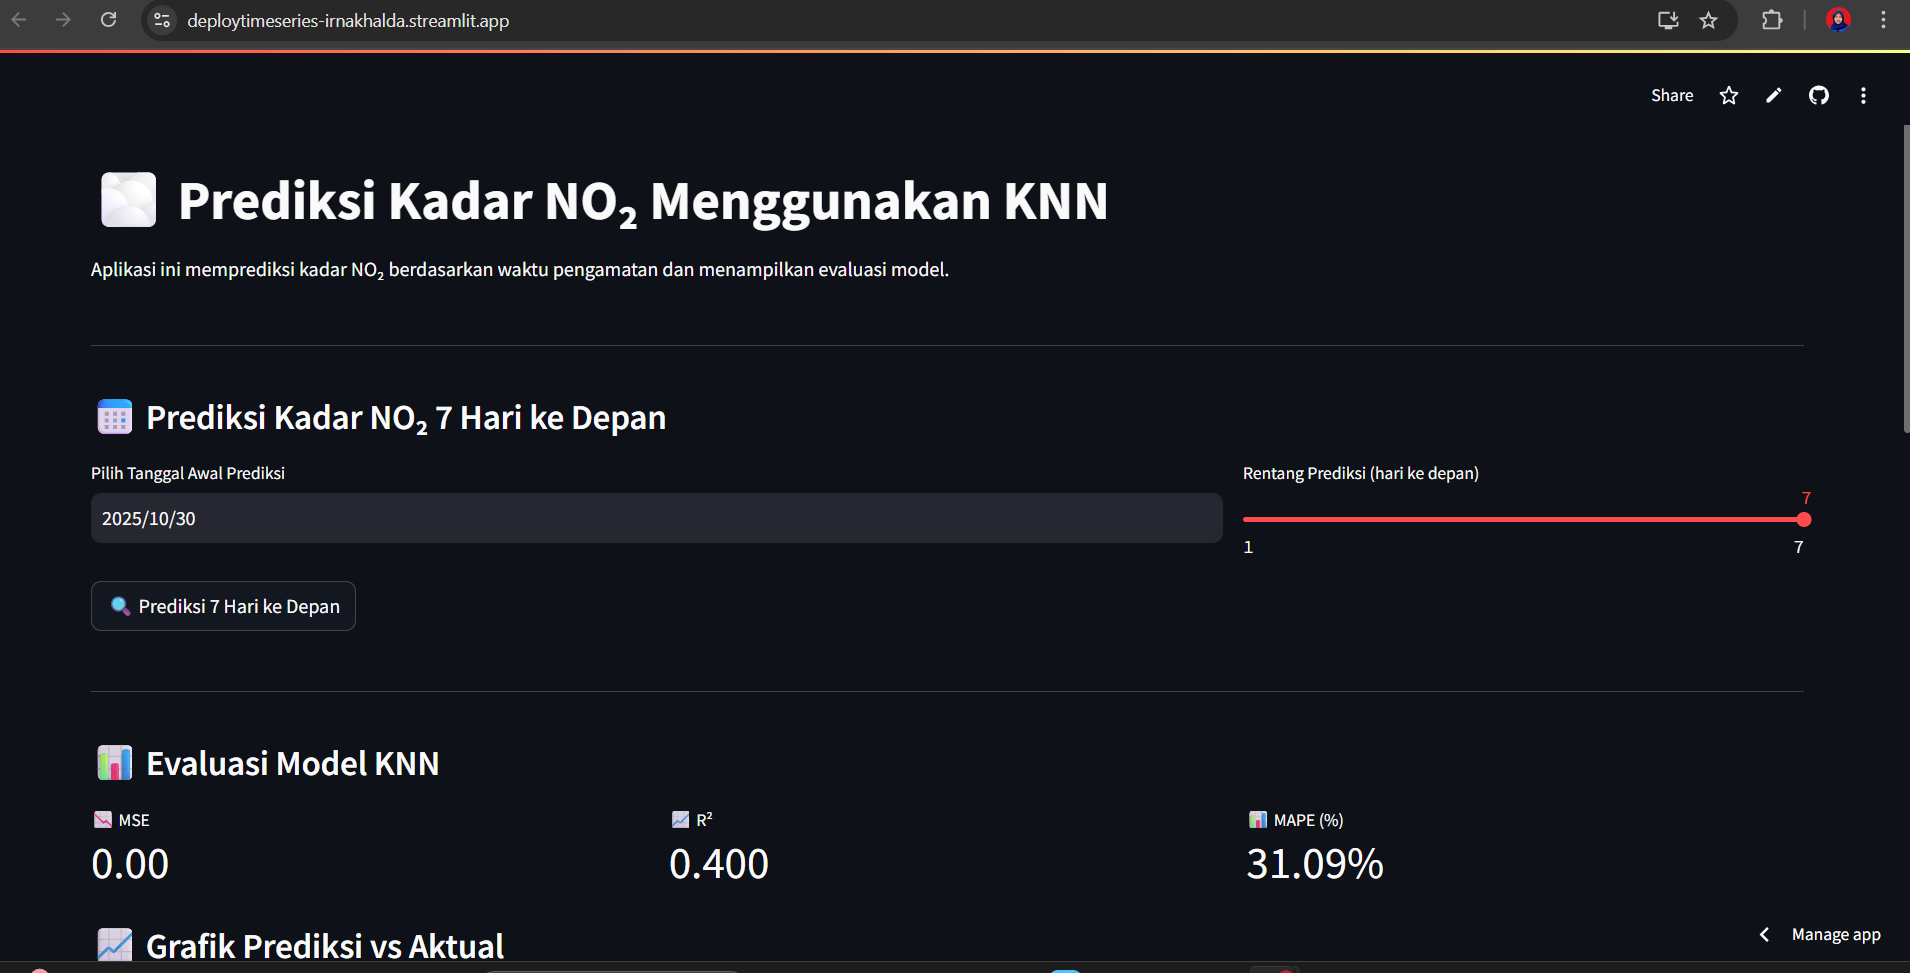

## link streamlit

https://deploytimeseries-irnakhalda.streamlit.app/